In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os
import pylab
%matplotlib inline

# Data preparation

In [2]:
data = pd.read_csv('H:/fast trip/Copy of KC_Metro_4_15_2014_OBS_Data.csv', index_col=0)
#clean data
data = data.loc[data['DWELL_SEC'] <= 90]
data = data[pd.notnull(data['ONS'])]
data = data[data.BUS_TYPE != '??']
#Converting categorical variables to factor 0 or 1 mark data
#Articulated bus or not
data['Artic'] = data['BUS_TYPE'].map({'Artic': 1, 'Standard': 0})
#2 or 3 doors 
data['twodoors'] = data['NUM_DOORS'].map({2: 1, 3: 0})
data['threedoors'] = data['NUM_DOORS'].map({2: 0, 3: 1})
data['TwoDoorsArtic'] = data.apply(lambda row: (row['twodoors']*row['Artic']), axis=1)
data['ThreeDoorsArtic'] = data.apply(lambda row: (row['threedoors']*row['Artic']), axis=1)
#Rapid ride or not
data['rapid_ride'] = data['RTE'].map({671: 1, 672: 1, 673: 1, 674: 1, 675: 1})
data.rapid_ride = data.rapid_ride.fillna(0)
#Downtown stop or not
dict_stop_id = dict((el,1) for el in [455, 456, 501, 502, 532, 533, 565, 566, 621, 622, 623, 624, 1082, 1083, 1084, 1086, 1108, 1109, 1121, 1122, 1192, 1193])
data['downtown_stop'] = data['STOP_ID'].map(dict_stop_id)
data.downtown_stop = data.downtown_stop.fillna(0)
print 'end'

end


In [3]:
#interactors
data['OnsTwoDoorsArtic'] = data.apply(lambda row: (row['ONS']*row['TwoDoorsArtic']), axis=1)
data['OffsTwoDoorsArtic'] = data.apply(lambda row: (row['OFFS']*row['TwoDoorsArtic']), axis=1)
data['OnsThreeDoorsArtic'] = data.apply(lambda row: (row['ONS']*row['ThreeDoorsArtic']), axis=1)
data['OffsThreeDoorsArtic'] = data.apply(lambda row: (row['OFFS']*row['ThreeDoorsArtic']), axis=1)
data['OnsRapid'] = data.apply(lambda row: (row['ONS']*row['rapid_ride']), axis=1)
data['OffsRapid'] = data.apply(lambda row: (row['OFFS']*row['rapid_ride']), axis=1)
data['OnsDowntown'] = data.apply(lambda row: (row['ONS']*row['downtown_stop']), axis=1)
data['OffsDowntown'] = data.apply(lambda row: (row['OFFS']*row['downtown_stop']), axis=1)
#Ons + Offs
data['ON+OFF'] = data.apply(lambda row: (row['ONS']+row['OFFS']), axis=1)
print 'end'

end


# Explore correlations of varaibles

225026.0
109478.0
115548.0


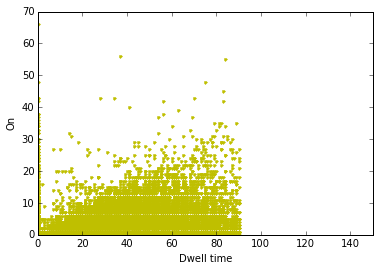

Std= 2.68591641082 ; Mean= 1.10138832998


In [4]:
print data['ON+OFF'].sum()
print data['ONS'].sum()
print data['OFFS'].sum()
x1 = data['ONS']
x2 = data['OFFS']
x3 = data['ON+OFF'] 

y = data['DWELL_SEC']
plt.plot(y,x1,'y.')
#plt.plot(y,x2,'b.')
#plt.plot(x3,y,'r.')
plt.axis([0,150,0,70])
plt.xlabel('Dwell time')
plt.ylabel('On')
plt.show()
s = np.std(x1)
m = np.mean(x1)
print 'Std=',s,'; Mean=', m

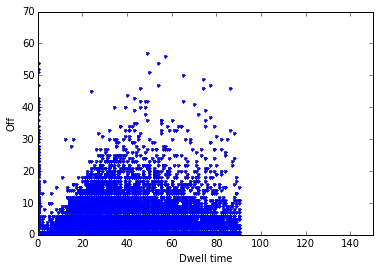

Std= 2.88040748753 ; Mean= 1.16245472837


In [5]:
plt.plot(y,x2,'y.')
plt.plot(y,x2,'b.')
#plt.plot(x3,y,'r.')
plt.axis([0,150,0,70])
plt.xlabel('Dwell time')
plt.ylabel('Off')
plt.show()
s = np.std(x2)
m = np.mean(x2)
print 'Std=',s,'; Mean=', m

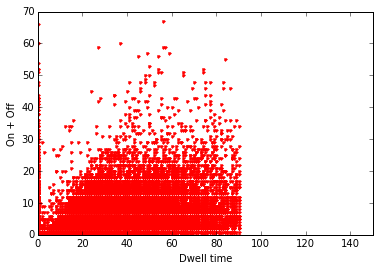

Std= 4.15848076745 ; Mean= 2.26384305835


In [6]:
plt.plot(y,x3,'r.')
plt.axis([0,150,0,70])
plt.xlabel('Dwell time')
plt.ylabel('On + Off')
plt.show()
s = np.std(x3)
m = np.mean(x3)
print 'Std=',s,'; Mean=', m

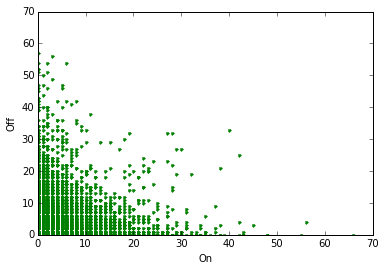

Std= 2.68591641082 ; Mean= 1.10138832998


In [7]:
plt.plot(x1,x2,'g.')
plt.axis([0,70,0,70])
plt.xlabel('On')
plt.ylabel('Off')
plt.show()
s = np.std(x1)
m = np.mean(x1)
print 'Std=',s,'; Mean=', m

In [8]:
#correlation table
results = data[['ONS', 'OFFS','ON+OFF', 'TwoDoorsArtic', 'ThreeDoorsArtic', 'rapid_ride', 'downtown_stop']]
results.corr()

,ONS,OFFS,ON+OFF,TwoDoorsArtic,ThreeDoorsArtic,rapid_ride,downtown_stop
ONS,1.000000,0.115172,0.725664,0.061322,0.122363,0.120958,0.183448
OFFS,0.115172,1.000000,0.767047,0.065238,0.120609,0.117127,0.140010
ON+OFF,0.725664,0.767047,1.000000,0.084795,0.162573,0.159254,0.215467
TwoDoorsArtic,0.061322,0.065238,0.084795,1.000000,-0.365539,-0.320056,0.177912
ThreeDoorsArtic,0.122363,0.120609,0.162573,-0.365539,1.000000,0.875573,-0.065034
rapid_ride,0.120958,0.117127,0.159254,-0.320056,0.875573,1.000000,-0.056942
downtown_stop,0.183448,0.140010,0.215467,0.177912,-0.065034,-0.056942,1.000000


# Cross Testing and try different variables

In [9]:
#Appling 90% of data as train dataset, 10% as test dataset
msk = np.random.rand(len(data)) < 0.9
df_train = data[msk]
df_test = data[~msk]
####another method#########################
#from sklearn.cross_validation import train_test_split
#data_train, data_test = train_test_split(data, test_size = 0.9, random_state=42)
print len(df_train), len(df_test)

89465 9935


In [10]:
lm = smf.ols(formula = 'DWELL_SEC ~ ONS + OFFS + ThreeDoorsArtic + TwoDoorsArtic+  rapid_ride + downtown_stop + OnsTwoDoorsArtic + OffsTwoDoorsArtic + OnsThreeDoorsArtic + OffsThreeDoorsArtic + OnsRapid + OffsRapid + OnsDowntown + OffsDowntown', data = df_train).fit()
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:              DWELL_SEC   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     4619.
Date:                Tue, 15 Dec 2015   Prob (F-statistic):               0.00
Time:                        13:04:15   Log-Likelihood:            -3.5245e+05
No. Observations:               89465   AIC:                         7.049e+05
Df Residuals:                   89450   BIC:                         7.051e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               4.1850    

# Appling the dewell time model with the rest 10% data

In [11]:
#Estimate dwell time for the 'test' dataset
df_est = []
df_est = pd.DataFrame(lm.predict(df_test), index = df_test.index, columns = ['Dwell_Time_Esti'])
df_test = pd.concat([df_test, df_est], axis=1, join='inner')
df_test.head()

,PATTERN_ID,BLK,RTE,DIR,SCH_ST_MIN,OPD_DATE,VEHICLE_ID,BUS_TYPE,ENGINE,NUM_DOORS,...,OnsTwoDoorsArtic,OffsTwoDoorsArtic,OnsThreeDoorsArtic,OffsThreeDoorsArtic,OnsRapid,OffsRapid,OnsDowntown,OffsDowntown,ON+OFF,Dwell_Time_Esti
TRIP_ID,,,,,,,,,,,,,,,,,,,,,
24176179,30215060,21501,215,W,298,15-Apr-14,6887,Artic,Motor,2,...,0,0,0,0,0,0,0,0,0,6.744742
18114004,10187008,18201,187,N,313,15-Apr-14,7041,Standard,Motor,2,...,0,0,0,0,0,0,0,0,0,4.185002
18113137,10158011,15801,158,N,294,15-Apr-14,6874,Artic,Motor,2,...,3,0,0,0,0,0,0,0,3,16.671666
21739187,41050314,5002,50,E,340,15-Apr-14,1103,Standard,Motor,2,...,0,0,0,0,0,0,0,0,0,4.185002
22939152,21671013,67102,671,S,270,15-Apr-14,6002,Artic,Motor,3,...,0,0,0,0,0,0,0,0,0,11.081368


# Plotting Scatter

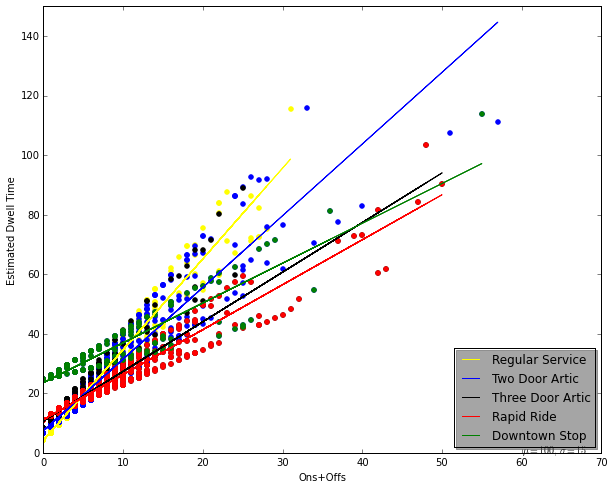

In [16]:
#Create dataframe for specific groups
df_test_TwoDoorsArtic = df_test[(df_test.TwoDoorsArtic==1)]
df_test_ThreeDoorsArtic = df_test[(df_test.ThreeDoorsArtic==1)]
df_test_StandardService = df_test[df_test.Artic==0]
df_test_RapidRide = df_test[df_test.rapid_ride==1]
df_test_DowntownStop = df_test[df_test.downtown_stop==1]


# plot the data itself
fig, ax = plt.subplots()
x3 = df_test_StandardService['ON+OFF']
y3 = df_test_StandardService['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x3, y3, color = 'yellow')
#plot the trend line
fit = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit[0] * x3 + fit[1], color='yellow', label= 'Regular Service')

# plot the data itself
x1 = df_test_TwoDoorsArtic['ON+OFF']
y1 = df_test_TwoDoorsArtic['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Two Door Artic')

x2 = df_test_ThreeDoorsArtic['ON+OFF']
y2 = df_test_ThreeDoorsArtic['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x2, y2, color = 'black')
#plot the trend line
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='black', label='Three Door Artic')


x4 = df_test_RapidRide['ON+OFF']
y4 = df_test_RapidRide['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x4, y4, color = 'red')
#plot the trend line
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='red', label= 'Rapid Ride')

x5 = df_test_DowntownStop['ON+OFF']
y5 = df_test_DowntownStop['Dwell_Time_Esti']
# plot the data itself
ax.scatter(x5, y5, color = 'green')
#plot the trend line
fit = np.polyfit(x5, y5, deg=1)
ax.plot(x5, fit[0] * x5 + fit[1], color='green', label='Downtown Stop')


plt.xlabel('Ons+Offs')
plt.ylabel('Estimated Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
#plt.figure(figsize=(10,5))
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()

#three doors trend is exactly as same as rapid ride bus... 

# Basic analysis....continued

In [17]:
#big picture
df_data_Artic = data[data.Artic==1]
df_data_StandardService = data[data.Artic==0]
df_data_RapidRide = data[data.rapid_ride==1]
df_data_DowntownStop = data[data.downtown_stop==1]
df_data_ThreeDoors = data[data.NUM_DOORS==3]
print 'Total usable sample size:', len(data)
print 'Standard bus:', len(df_data_StandardService)
print 'Articulated bus:', len(df_data_Artic)
print '3-doors bus (all of them are belong to articulated bus service):', len(df_data_ThreeDoors)
print 'Rapid Ride only (all of them are belong to articulated bus service):', len(df_data_RapidRide)
print 'Downtown Stop only (all of them are belong to articulated bus service):', len(df_data_DowntownStop)
#print len(df_data_StandardService)+len(df_data_Artic)+len(df_data_RapidRide)+len(df_data_DowntownStop)

Total usable sample size: 99400
Standard bus: 44929
Articulated bus: 54471
3-doors bus (all of them are belong to articulated bus service): 19955
Rapid Ride only (all of them are belong to articulated bus service): 16050
Downtown Stop only (all of them are belong to articulated bus service): 1646


In [18]:
#rapid ride
df_data_RapidRide_threedoors = df_data_RapidRide[df_data_RapidRide.NUM_DOORS==3]
print len(df_data_RapidRide_threedoors)

16050


In [19]:
#downtown
df_data_DowntownStop_threedoors = df_data_DowntownStop[df_data_DowntownStop.NUM_DOORS==3]
df_data_DowntownStop_twodoors = df_data_DowntownStop[df_data_DowntownStop.NUM_DOORS==2]
print len(df_data_DowntownStop_threedoors)
print len(df_data_DowntownStop_twodoors)

0
1646


In [20]:
#number of doors
#data = data.loc[data['DWELL_SEC'] <= 90]
twodoor = data.loc[data['threedoors']==0]
threedoor = data.loc[data['threedoors']==1]
print len(twodoor)
print len(threedoor)
print len(data)
print len(df_data_RapidRide) #the problem here is 

79445
19955
99400
16050
